In [1]:
import torch
from superclap.model_train import SuperCLAPTrainer
from superclap.config import config
from superclap.alignment import align_textgrid_with_source_text
from superclap.audio import load_mono_audio, spectogram
from training.datasets import load_item, collate

In [2]:
checkpoint = torch.load(f'./output/exp-02.pt', map_location="cpu")
model = SuperCLAPTrainer()
model.load_state_dict(checkpoint['model'])
model.eval()

SuperCLAPTrainer(
  (audio_encoder): AudioEncoder(
    (transformer_input): Linear(in_features=100, out_features=256, bias=True)
    (conv_embed): ConvPositionEmbed(
      (dw_conv1d): Sequential(
        (0): Conv1d(256, 256, kernel_size=(31,), stride=(1,), padding=(15,), groups=256)
        (1): GELU(approximate='none')
      )
    )
    (transformer): Transformer(
      (layers): ModuleList(
        (0-3): 4 x AttentionBlock(
          (attention_ln): RMSNorm()
          (attention): Attention(
            (attention_q): Linear(in_features=256, out_features=128, bias=False)
            (attention_k): Linear(in_features=256, out_features=128, bias=False)
            (attention_v): Linear(in_features=256, out_features=128, bias=False)
            (attention_output): Linear(in_features=128, out_features=256, bias=False)
          )
          (mlp_ln): RMSNorm()
          (mlp): AttentionMLP(
            (mlp_input): Linear(in_features=256, out_features=1024, bias=True)
            (mlp

In [3]:
waveform, spec, audio_segments, combined_alignments = load_item("./external_datasets/librilight-processed/100/2315/01_baum_sea_fairies_64kb_0002")
audio, audio_lengths, alignments = collate([(audio_segments, combined_alignments)])
text_embeddings, audio_embeddings, loss = model(audio = audio, audio_lengths = audio_lengths, alignment = alignments)
similarity_matrix = audio_embeddings @ audio_embeddings.T

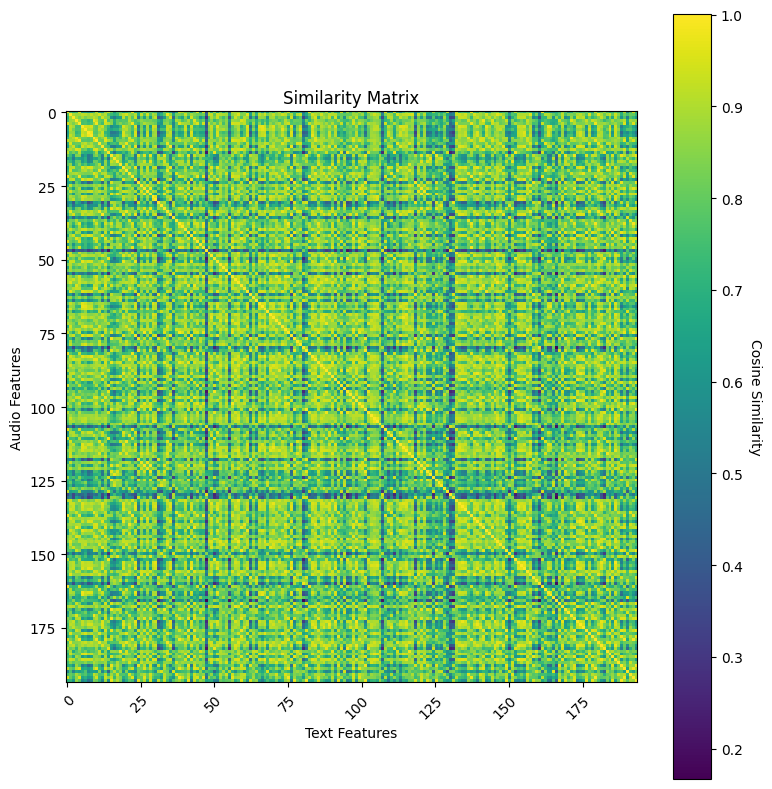

In [4]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 8))
    
# Display the similarity matrix as an image
im = ax.imshow(similarity_matrix.detach(), cmap='viridis', interpolation='nearest')
    
# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Cosine Similarity', rotation=-90, va="bottom")
    
# Set axis labels and title
# ax.set_xticks(range(len(text_embeddings)))
# ax.set_yticks(range(len(audio_embeddings)))
# ax.set_xticklabels(['Text {}'.format(i+1) for i in range(len(text_embeddings))])
# ax.set_yticklabels(['Audio {}'.format(i+1) for i in range(len(audio_embeddings))])
ax.set_xlabel('Text Features')
ax.set_ylabel('Audio Features')
ax.set_title('Similarity Matrix')
    
# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
# Adjust the layout and display the plot
fig.tight_layout()
plt.show()

In [5]:
model = model.to("cuda")
text_embeddings, audio_embeddings, loss = model(audio = spec.unsqueeze(0).to("cuda"), alignment = [combined_alignments])

TypeError: SuperCLAPTrainer.forward() missing 1 required keyword-only argument: 'audio_lengths'